# Error and uncertainty in figures 1.3 and 1.4

Assessing uncertainty in machine learning is not easy, but it can be done.

#### random uncertainty
The figures printed in the book provide some initial sense of variation; for instance in figure 1.3, I have repeated the modeling process 15 times on each slice of the timeline, taking 150 different volumes each time. There's a lot of random variation, but the change across the timeline (from 1700 to 2000) is clearly significant in spite of variation.

#### systematic error
However, random resampling doesn't get at deeper sources of uncertainty, related to error in the data itself. 
The differentiation of biography and fiction is one of the broadest, slowest changes I'll trace in this book, so I really needed three hundred years of literary history to cover it. That draws me deeper into the eighteenth century than usual, and eighteenth-century data can be fairly messy. So the data used here is some of the dirtiest data in the book, especially in the early going. We need to ask ourselves whether classifiers perform more poorly in the eighteenth century because of that underlying error in the data.

Exploring all the ins and outs of that question would have weighed down a book that needs to be lively and brief. But I do want to explore the ins and outs, in order to assess the significance of potential problems. Thus, this notebook.

### Sources of error in the data

There are several overlapping problems. One of the fundamental ones is that there's just not all that *much* fiction in the early eighteenth century. Getting hundreds of examples is not always straightforward; we're going to have lots of duplicates of a few works (Quixote, Crusoe).

Less fundamental: OCR accuracy is low in the eighteenth century. This doesn't turn out to be a huge problem, but we'll need to confirm that.

#### the biggest problem
The biggest and deepest problem is that the boundary between fiction and biography is notoriously blurry, and especially so in the eighteenth century.

In a sense, this is no problem at all for my thesis. It's a version of the conclusion I am aiming to test! I'm trying to show that fiction and biography are hard to separate, and then get easier. If my test failed because the categories were too hard to separate in the eighteenth century *even to run the test*, that would actually confirm my thesis. 

But I need to make sure that any uncertainty about ground truth is real uncertainty, and not just sloppiness. Genre information gets less certain as we go back in time, partly because genres really get blurrier, and partly because library records are worse: genres just weren't systematically recorded for everything before the middle of the twentieth century. So I'm going to need to somehow supplement library categorization.

There are a number of ways to do that: machine learning, for instance, can work. But I can't use machine learning to construct a set of volumes whose coherence I want to test ... using machine learning! So I've used a mixture of existing genre metadata and suggestive title words (like "memoirs," "autobiography," "a novel," etc) to construct this data set.

That's a process that can create a lot of error. If you open ```hathigenremeta.csv``` and look for misclassified volumes, you will easily find dozens of them. The overall level of error is not enormous (roughly 8%). But error is unevenly distributed: the errors tend to be more common as we go back in time. That's very consequential for my thesis, because ground truth with more error could make genres harder to separate. I need to know that the differentiation of fiction and biography isn't purely a consequence of better ground truth.


### Things that aren't error

While assessing genuine problems, I also want to flag several aspects of the data that are definitional decisions, not errors. 

1. I'm using a very generous definition of "biography," covering any nonfiction that foregrounds narratives about individual human lives. Memoirs, journals, travel writing, history focused on the lives of individuals, all fit.
2. Also using a generous definition of fiction, not restricted to the novel. Short stories, folk tales, fictionalized "sketches" that aim to represent national or regional character, are all fair game.
3. In this dataset, I have not tried to exclude books for young readers. (I have done so in other datasets, used in later chapters.)
4. I don't care about precise titles; it makes no difference at all to the results.
5. I have not excluded reprints. There are about ten copies of *Crusoe* in this data.
6. The publication dates I'm using are dates of publication *for the volume,* not dates of first publication *for the work.* You will find a copy of *Crusoe* dated 1820, for instance. That's not an error; it's when the book was published.

Several of the choices above will be different in subsequent chapters (e.g. chapters 2 and 3 try to exclude reprints and date volumes as close as possible to first publication.) Critics of distant reading sometimes argue that one of these approaches to dating is wrong and the other is right. But in point of fact, results very rarely stand or fall on the choice between them. Here, for instance, the effect of excluding reprints would be to make change-over-time look slightly more dramatic. I could do that, if I wanted to emphasize the magnitude of my result. But the result also comes through perfectly clearly in a dataset that includes reprints.

### Strategy of error assessment

I manually corrected records covering three twenty-year periods:

1. 1740-59
2. 1840-59
3. 1940-59

Doing this allowed me first of all to measure the level of error itself, and see how much it changed over time. Secondly, and more importantly, it allowed me to see how much correcting the errors would change *the results reported by my classification algorithm.*

Below I report the results of manual correction. **changebiovsfic** are cases where biography was changed to fiction, or vice-versa; these could clearly reduce the accuracy of the classifier. **toothergenre** is a case where bio or fic were changed to some other genre. For instance, "fiction" might really have been drama, or "biography" might have been some other kind of nonfiction. These errors also matter, although their effect is less clear, and they might even have increased accuracy (since, say, botany could be easier to distinguish from fiction than biography would be).

In [17]:
import csv, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [3]:
error = pd.read_csv('allgenremetaerrors.csv')
error.head()

,decade,category,changebiovsfic,toothergenre,totalerrors,totalvols
0,1740,1740-59,6,5,11,99
1,1850,1840-59,5,6,11,131
2,1950,1940-59,0,4,4,139
3,1750,1740-59,13,13,26,146
4,1840,1840-59,4,6,10,132


I recorded error separately in each decade, but we want to sum into three groups:

In [6]:
groups = error.groupby('category')
summed = groups.aggregate(np.sum)
summed['errorpct'] = summed.totalerrors/summed.totalvols
summed.head()

,decade,changebiovsfic,toothergenre,totalerrors,totalvols,errorpct
category,,,,,,
1740-59,3490,19,18,37,245,0.151020
1840-59,3690,9,12,21,263,0.079848
1940-59,3890,2,6,8,277,0.028881


#### assessment

Error is clearly worse as we go back in time: this is a pattern that could be consequential for my thesis.

To be fully statistically responsible, let's provide a picture of our uncertainty about error itself.

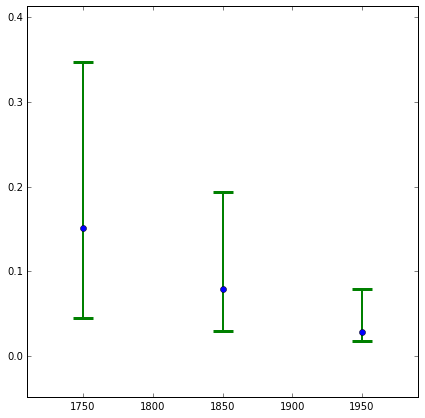

In [18]:
def resample(vector):
    '''resamples a vector of ones and zeroes
    and returns the count of ones'''

    resample = np.random.choice(vector, len(vector))
    return np.sum(resample) / len(resample)

def uncertainty(vector):
    ''' Returns 95% confidence bounds on 
    a bootstrap resampling.
    '''
    variations = []
    for i in range (1000):
        variations.append(resample(vector))
    return np.percentile(variations, [2.5, 50, 97.5])

lower_bounds = []
recorded = []
upper_bounds = []
xvals = [1750, 1850, 1950]

for category in summed.index:
    total = summed.loc[category, 'totalvols']
    errors = summed.loc[category, 'totalerrors']
    vector = [1] * errors
    vector.extend([0] * (total-errors))
    bottom, middle, top = uncertainty(vector)
    lower_bounds.append(bottom)
    recorded.append(middle)
    upper_bounds.append(top)

fig, ax = plt.subplots(figsize = (7, 7))
ax.margins(0.2)
ax.errorbar(xvals, recorded, yerr = [lower_bounds, upper_bounds], fmt = 'o',
           ecolor = 'g', capthick = 3, elinewidth = 2, capsize = 10)
plt.show()
        

That's a significant amount of error, and a pattern of error that could be consequential, because it gets worse as you go back in time.

It seemed necessary to manually correct a lot of data. So in addition to the three twenty-year periods described above (which I had corrected in the process of assessing error), I manually went through and tried to correct the bulk of the errors in the whole period 1700-1860. I don't promise to have solved all problems in the dataset; there's going to be some residue of error remaining. But I now believe the level of error is fairly constant across the timeline.

Looking at the difference error-correction made, I feel some confidence that focusing on the period before 1860 was a good strategy.

In [86]:
oldresults = pd.read_csv('../modeloutput/oldbiopredicts.csv')
newresults = pd.read_csv('../modeloutput/finalbiopredicts.csv')
newresults.head()

,center,accuracy
0,1720,0.926667
1,1720,0.926667
2,1720,0.913333
3,1720,0.953333
4,1720,0.953333


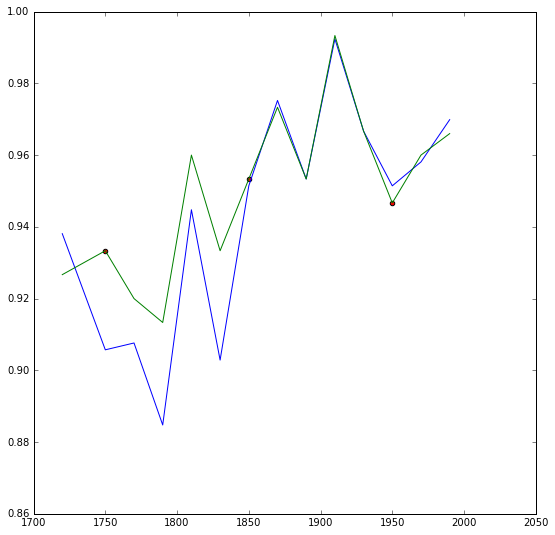

In [88]:
oldgroups = oldresults.groupby('center')
old = oldgroups.aggregate(np.mean)
newgroups = newresults.groupby('center')
new = newgroups.aggregate(np.median)
fig, ax = plt.subplots(figsize = (9, 9))
plt.plot(old.index, old.accuracy)
plt.plot(new.index, new.accuracy)
x = [1750, 1850, 1950]
y = []
centered_x = []
for x1 in x:
    y.append(new.loc[x1, 'accuracy'])
    centered_x.append(x1)
plt.scatter(centered_x, y, c = 'r')

plt.show()

#### assessment

The green line above is the evidence actually used in the book. The blue line is the evidence before cleaning. The periods I corrected while measuring error are marked with red dots.

You can see that the cleaning made a big difference in 1740-60, but relatively little in 1840-60 or 1940-60. You can also see that error correction in the period 1700-1860 has tended to shift up the green line (and straighten it to some extent).

There may be some error remaining across the dataset, but I feel fairly confident that I hit the bulk of the errors before 1860. Further correction would have diminishing returns, and given the relatively modest scale of the change between the blue line and the green one, I feel confident that diminishing returns are not going to erase the rising slope of the green line. So I feel confident in saying that classifiers get more accurate across the timeline (at least up to 1920 or so) -- suggesting a pattern of generic differentiation.

### Could this result be a mistake, caused by bad eighteenth-century OCR?

Perhaps inaccurate transcriptions in the 18c could be making volumes harder to classify?

While this might seem intuitively plausible, my experience has been that OCR quality makes little difference to predictive classification. The classifier doesn't care about correct spelling. As long as volumes are distorted in roughly similar ways, a classifier can still recognize internal differences and similarities in a misspelled corpus.

But don't take my word for that. We can test the thesis by running biography vs. fiction classification on a set of 18c volumes that were manually transcribed by TCP-ECCO. These should have almost no transcription errors. However, accuracy is by no means higher.

In [78]:
ecco_df = pd.read_csv('../modeloutput/eccopredicts.csv')
hathi_df = pd.read_csv('../modeloutput/finalbiopredicts.csv')
hathi_df.head()

,center,accuracy
0,1720,0.940000
1,1720,0.913333
2,1720,0.946667
3,1720,0.940000
4,1720,0.933333


In [80]:
eccoaverage = sum(ecco_df.accuracy) / len(ecco_df.accuracy)
print('Average accuracy on TCP-ECCO volumes (1700-1800): ' + str(eccoaverage))

hathiaverage = (sum(hathi_df[hathi_df.center < 1800].accuracy) / len(hathi_df[hathi_df.center < 1800].accuracy))
print('Average accuracy on Hathi volumes (1702-1800): '+ str(hathiaverage))

Average accuracy on TCP-ECCO volumes (1700-1800): 0.826666666667
Average accuracy on Hathi volumes (1702-1800): 0.92511111111


#### assessment

The OCR for Hathi volumes is much worse than manual transcription for ECCO. But accuracy is higher for Hathi. Probably what matters is that the Hathi volumes are longer, and more likely to be novels: ECCO has a lot of pamphlets that are hard to classify as satire, biography, or fiction. In any case we don't have a lot of evidence that OCR is a limiting factor on accuracy.